In [1]:
import sys
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time

sys.path.append('..')
from stattool.empirical_design import check_aa
from stattool.plot_tool import plot_cdf
from scipy.stats import norm, ttest_ind
from stattool import deltamethod
from stattool.theoretical_design import get_parameter_size
from stattool.experiment_tool import conduct_test, format_results

In [2]:
df = pd.read_parquet('../dataset/prepared_trips.parquet')

# Primary analysis

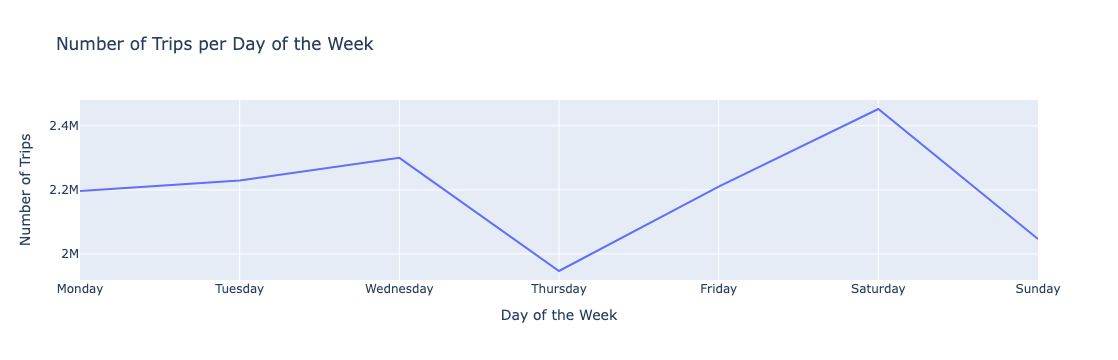

In [3]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
trips_per_day = df['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

fig = px.line(
    x=trips_per_day.index,
    y=trips_per_day.values,
    labels={'x': 'Day of the Week', 'y': 'Number of Trips'},
    title='Number of Trips per Day of the Week'
)
fig.show()

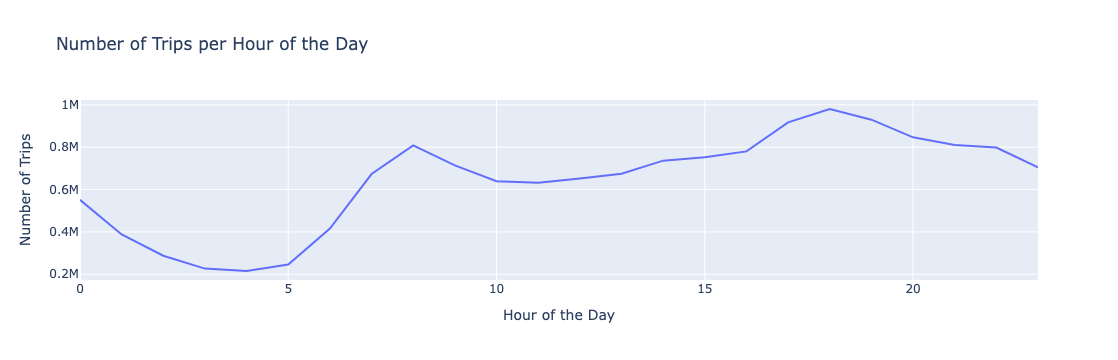

In [4]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
trips_per_hour = df['hour_of_day'].value_counts().sort_index()

fig = px.line(
    x=trips_per_hour.index,
    y=trips_per_hour.values,
    labels={'x': 'Hour of the Day', 'y': 'Number of Trips'},
    title='Number of Trips per Hour of the Day'
)
fig.show()



office workers patterns 
lets check if it differs by day 

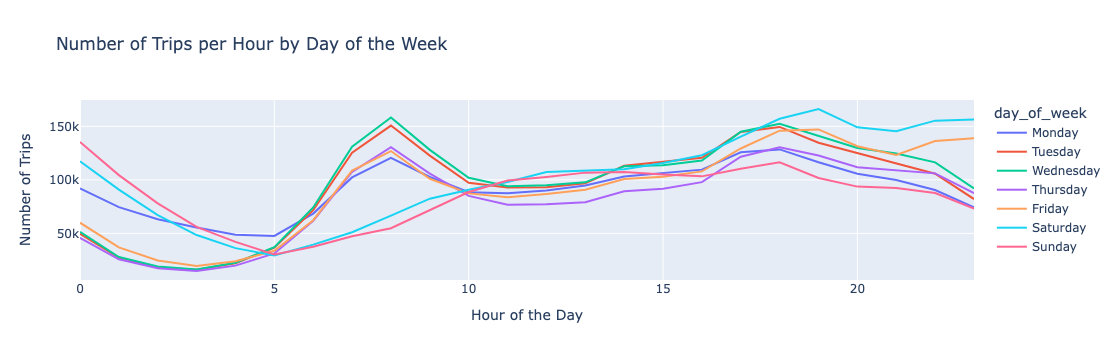

In [5]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

grouped = df.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='trip_count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped['day_of_week'] = pd.Categorical(grouped['day_of_week'], categories=day_order, ordered=True)
grouped = grouped.sort_values(['day_of_week', 'hour_of_day'])

fig = px.line(
    grouped,
    x='hour_of_day',
    y='trip_count',
    color='day_of_week',
    labels={'hour_of_day': 'Hour of the Day', 'trip_count': 'Number of Trips'},
    title='Number of Trips per Hour by Day of the Week'
)
fig.show()


as expected on working days (mon-friday) peak in the morning, lower number of trips during nights
and on sat and sun vice versa

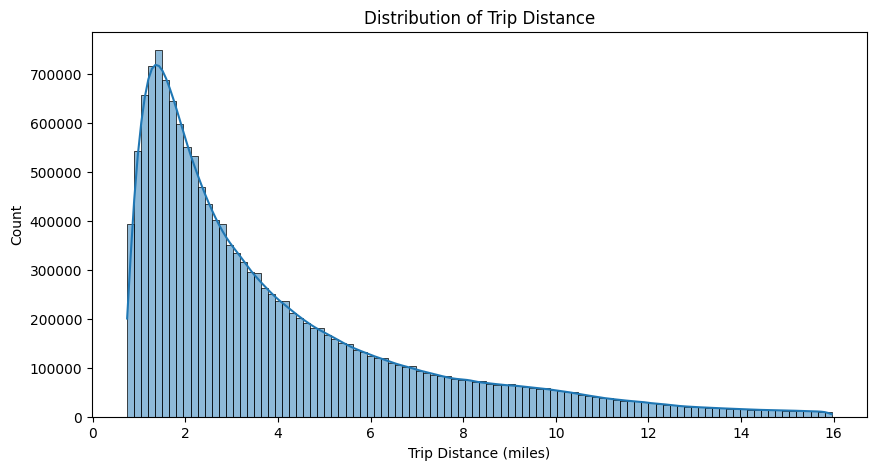

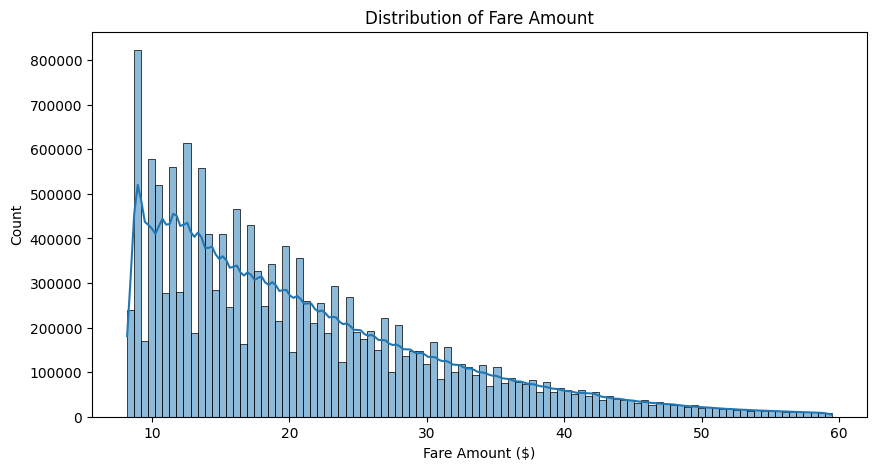

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df['trip_miles'], bins=100, kde=True)
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['base_passenger_fare'], bins=100, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Count')
plt.show()



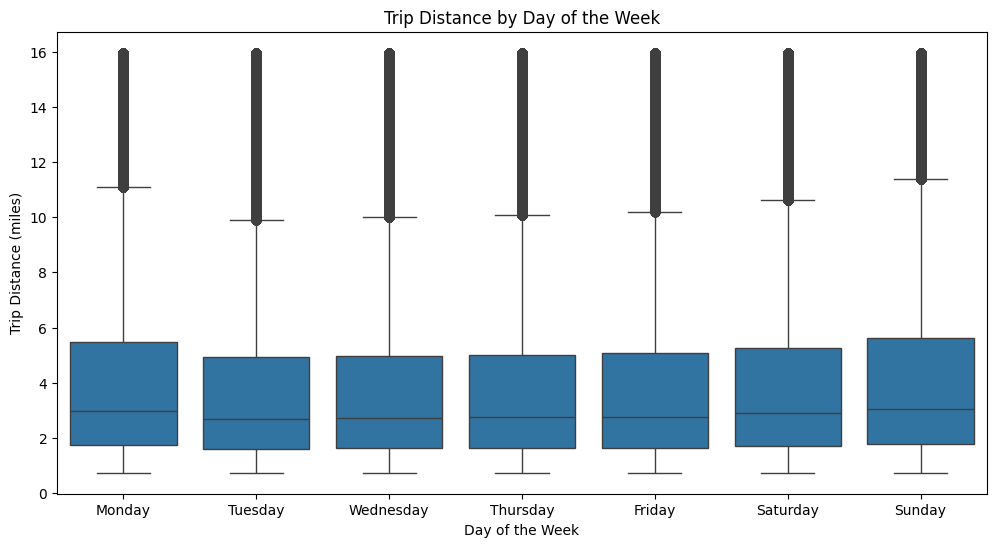

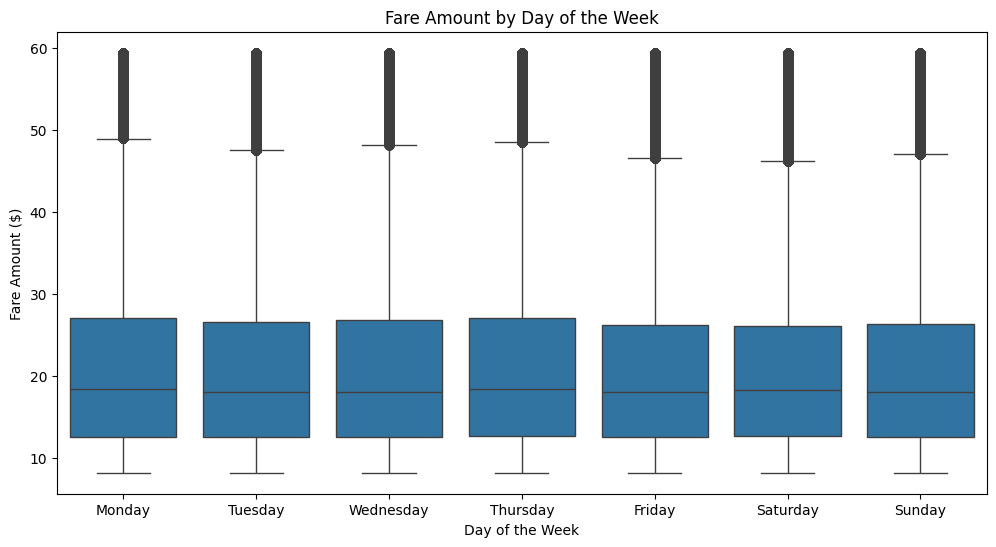

In [7]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='day_of_week', y='trip_miles', order=order)
plt.title('Trip Distance by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Trip Distance (miles)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='day_of_week', y='base_passenger_fare', order=order)
plt.title('Fare Amount by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fare Amount ($)')
plt.show()



KeyboardInterrupt



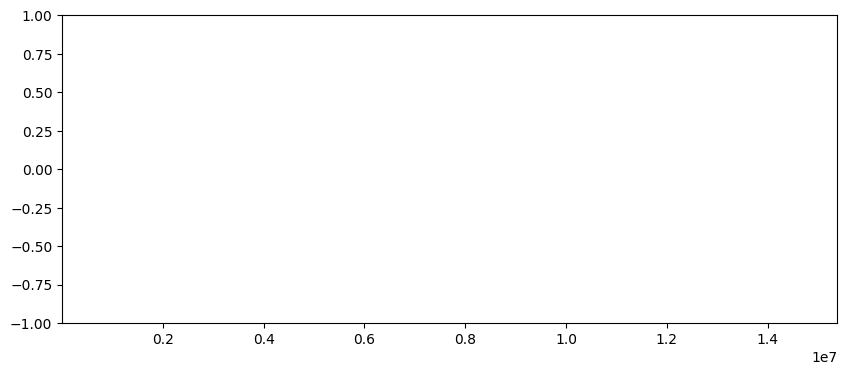

In [8]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
autocorrelation_plot(df['trip_miles'].dropna())
plt.title('Autocorrelation of Trip Distance')
plt.show()

plt.figure(figsize=(10, 4))
autocorrelation_plot(df['base_passenger_fare'].dropna())
plt.title('Autocorrelation of Fare Amount')
plt.show()


In [ ]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

corr = df[['PULocationID', 'DOLocationID', 
           'trip_miles', 'trip_time', 'base_passenger_fare', 
           'congestion_surcharge', 'driver_pay',
           'hour_of_day', 'day_of_week']].corr()

sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True,
            cmap='coolwarm', 
            ax=ax)
plt.title('Correlation Matrix')
plt.show()


# Preparing Data

In [2]:
def get_trad_df(completed_cars_file, number, co2_per_km=4.8, agg=2):
    date_range = pd.date_range(
        start="2024-01-01 00:00:00", 
        end="2024-02-01 00:00:00", 
        freq=f"{agg}min"
    )
    on_line_cars = pd.DataFrame({"agg": date_range})
    on_line_cars["hour"] = on_line_cars["agg"].dt.hour
    on_line_cars["on_line_time"] = on_line_cars["hour"].apply(
    lambda x: 840 * number if (x < 21) and (x >= 6) else 0
    )
    
    trips_table = pd.read_parquet(f'../results/{completed_cars_file}')
    
    trips_table['agg'] = trips_table['request_datetime'].dt.floor(f"{agg}min")
    trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee'] - trips_table['driver_pay']
    trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']

    metrics = trips_table.pivot_table(index='agg', 
                            columns='assigned', 
                            values='trip_id', 
                            aggfunc='count',
                            fill_value=0).reset_index().rename(columns={False:'missed_trips', True:'completed_trips'})
    
    assigned = trips_table[trips_table['assigned'] == True]
    assigned_metrics = assigned.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                    .rename(columns={'trip_time': 'time_with_passenger'})

    metrics = metrics.merge(assigned_metrics, on='agg', how='left')
    
    metrics = metrics.merge(on_line_cars, on='agg', how='left')
    
    metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']
    metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

    metrics['default'] = 1

    metrics[['missed_trips', 'completed_trips', 'net_revenue', 'revenue',
       'time_with_passenger', 'trip_miles', 'hour', 'on_line_time',
       'cnt_trips', 'co2_emissions']] = metrics[['missed_trips', 'completed_trips', 'net_revenue', 'revenue',
       'time_with_passenger', 'trip_miles', 'hour', 'on_line_time',
       'cnt_trips', 'co2_emissions']].fillna(0)

    return metrics
    

In [3]:
def get_df_from_files(on_line_cars_files, completed_cars_file, co2_per_km = 0.4, agg=3, include_driver_pay=True):
    on_line_cars = pd.read_parquet(f'../results/{on_line_cars_files}')
    on_line_cars['agg'] = pd.to_datetime(on_line_cars['timestamp']).dt.floor(f'{agg}min')
    
    trips_table = pd.read_parquet(f'../results/{completed_cars_file}')
    
    trips_table['agg'] = trips_table['request_datetime'].dt.floor(f'{agg}min')
    trips_table['net_revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']
    if include_driver_pay:
        trips_table['net_revenue'] -= trips_table['driver_pay']
    trips_table['revenue'] = trips_table['base_passenger_fare'] + trips_table['airport_fee']

    metrics = trips_table.pivot_table(index='agg', 
                            columns='assigned', 
                            values='trip_id', 
                            aggfunc='count',
                            fill_value=0).reset_index().rename(columns={False:'missed_trips', True:'completed_trips'})
    
    assigned = trips_table[trips_table['assigned'] == True]
    metrics_assigned = assigned.groupby('agg')[['net_revenue', 'revenue', 'trip_time', 'trip_miles']].sum().reset_index()\
                    .rename(columns={'trip_time': 'time_with_passenger'})

    metrics = metrics.merge(metrics_assigned, on='agg', how='left')
    
    aggregated_on_line_cars = on_line_cars.groupby(['agg', 'car_id'])['timestamp'].agg(['min', 'max'])
    aggregated_on_line_cars['on_line_time'] = (pd.to_datetime(aggregated_on_line_cars['max']) - pd.to_datetime(aggregated_on_line_cars['min']))\
                                .dt.total_seconds()
    metrics = metrics.merge(aggregated_on_line_cars.groupby(['agg'])['on_line_time'].sum().reset_index(), on='agg', how='left')
    
    metrics['cnt_trips'] = metrics['completed_trips'] + metrics['missed_trips']
    metrics['co2_emissions'] = co2_per_km * metrics['trip_miles'] * 0.62 # 06 miles = 1 km 

    metrics['default'] = 1

    metrics[['missed_trips', 'completed_trips', 'net_revenue', 'revenue',
       'time_with_passenger', 'trip_miles', 'on_line_time',
       'cnt_trips', 'co2_emissions']] = metrics[['missed_trips', 'completed_trips', 'net_revenue', 'revenue',
       'time_with_passenger', 'trip_miles', 'on_line_time',
       'cnt_trips', 'co2_emissions']].fillna(0)

    return metrics

In [4]:
fleet_sizes = [100, 500, 1000, 2000, 3500]

df = pd.DataFrame()

for fleet in fleet_sizes:
    saev = get_df_from_files(f'saev_online_cars_day_{fleet}.parquet', f'saev_completed_trips_day_{fleet}.parquet', include_driver_pay=False)
    trad = get_trad_df(f'trad_completed_trips_day_{fleet}.parquet', fleet)
    hailing = get_df_from_files(f'hailing_platform_online_cars_day_{fleet}.parquet', f'hailing_platform_completed_trips_day_{fleet}.parquet', co2_per_km=4.8)

    saev['group'] = 'saev'
    trad['group'] = 'trad'
    hailing['group'] = 'hailing'

    res = pd.concat([saev, trad, hailing])
    res['fleet_size'] = fleet

    df = pd.concat([res, df], ignore_index=True)
    print('Downloaded fleet_size', fleet)

Downloaded fleet_size {100}
Downloaded fleet_size {500}
Downloaded fleet_size {1000}
Downloaded fleet_size {2000}
Downloaded fleet_size {3500}


In [5]:
# quick sanity check 
df.groupby(['group', 'fleet_size'])['net_revenue'].median()

group    fleet_size
hailing  100             50.090
         500            256.580
         1000           499.600
         2000           979.515
         3500          1210.425
saev     100            182.790
         500            920.270
         1000          1804.300
         2000          3521.480
         3500          4740.290
trad     100             19.260
         500            138.620
         1000           295.540
         2000           583.690
         3500           691.160
Name: net_revenue, dtype: float64

In [6]:
df.columns

Index(['agg', 'missed_trips', 'completed_trips', 'net_revenue', 'revenue',
       'time_with_passenger', 'trip_miles', 'on_line_time', 'cnt_trips',
       'co2_emissions', 'default', 'group', 'hour', 'fleet_size'],
      dtype='object')

In [7]:
df.to_csv('metric_results.csv')

In [3]:
df = pd.read_csv('metric_results.csv')

In [4]:
df.loc[df['group'] == 'hailing', 'co2_emissions'] = df['trip_miles'] * 4.8

# Main Analysis

## Economic analysis

In [3]:
df['agg'] = pd.to_datetime(df['agg'])
df['day_of_week'] = df['agg'].dt.day_name()
df['hour_of_day'] = df['agg'].dt.hour

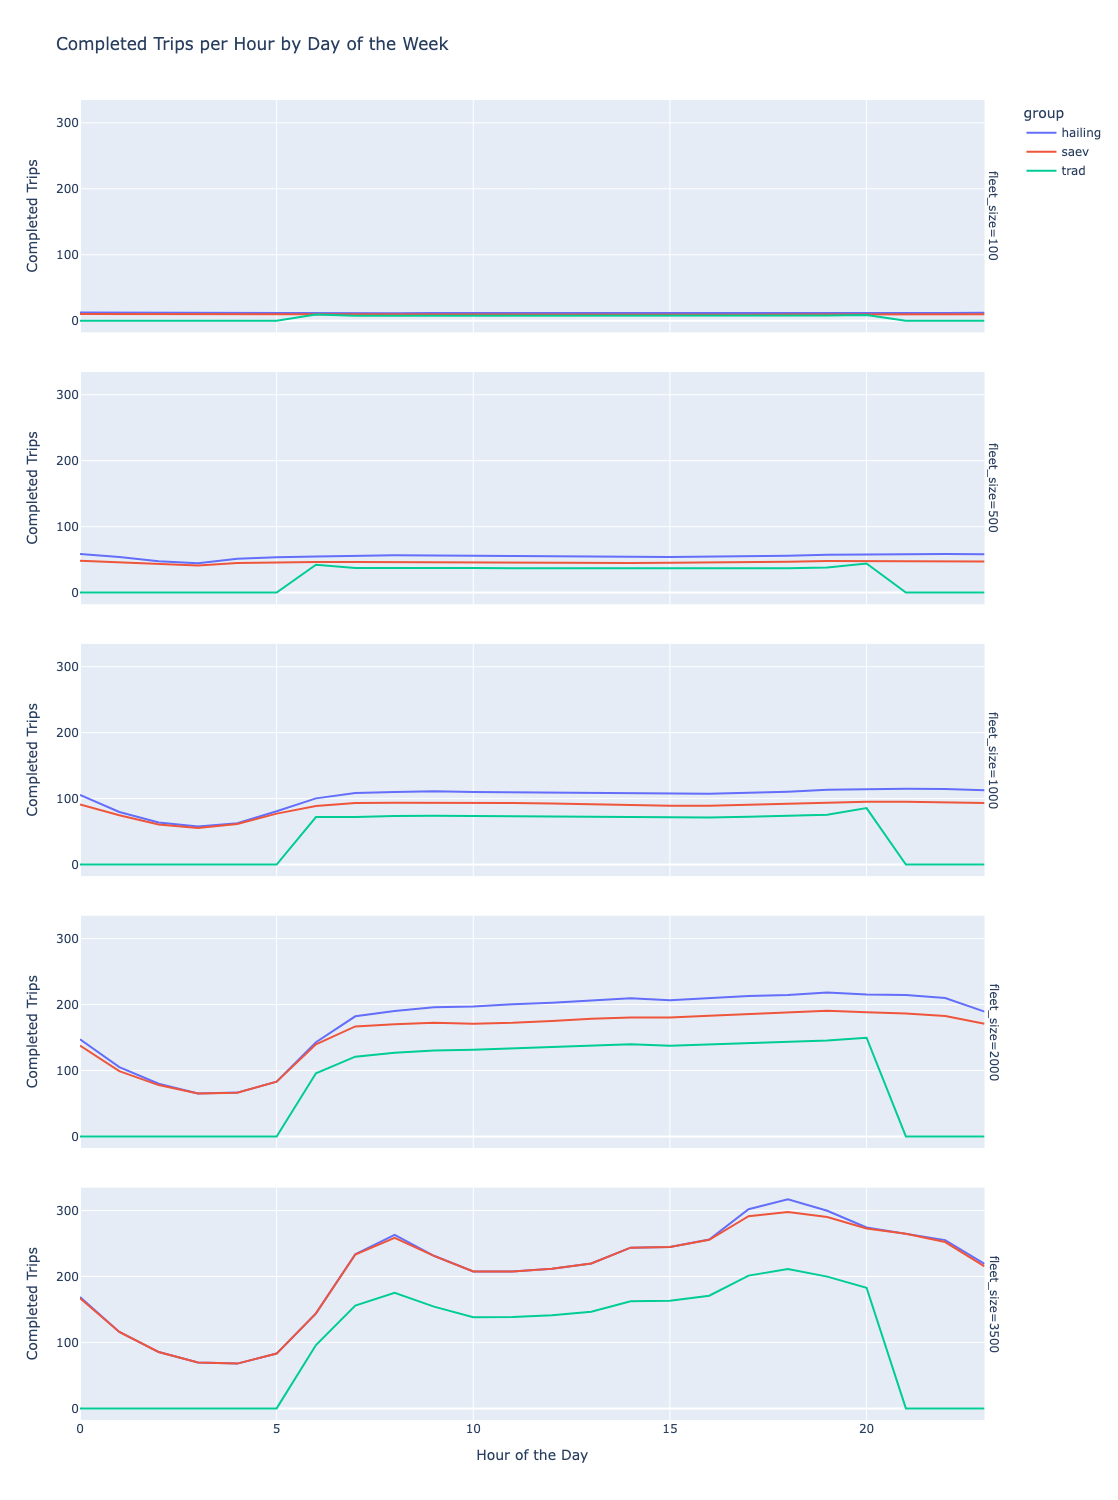

In [4]:
grouped = df.groupby(['hour_of_day', 'fleet_size', 'group'])['completed_trips'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped = grouped.sort_values(['hour_of_day', 'fleet_size', 'group'])

fig = px.line(
    grouped,
    x='hour_of_day',
    y='completed_trips',
    color='group',
    facet_row='fleet_size',
    labels={'hour_of_day': 'Hour of the Day', 'completed_trips': 'Completed Trips'},
    title='Completed Trips per Hour by Day of the Week'
)
fig.update_layout(
    height=1500,
    width=1100
)
fig.show()

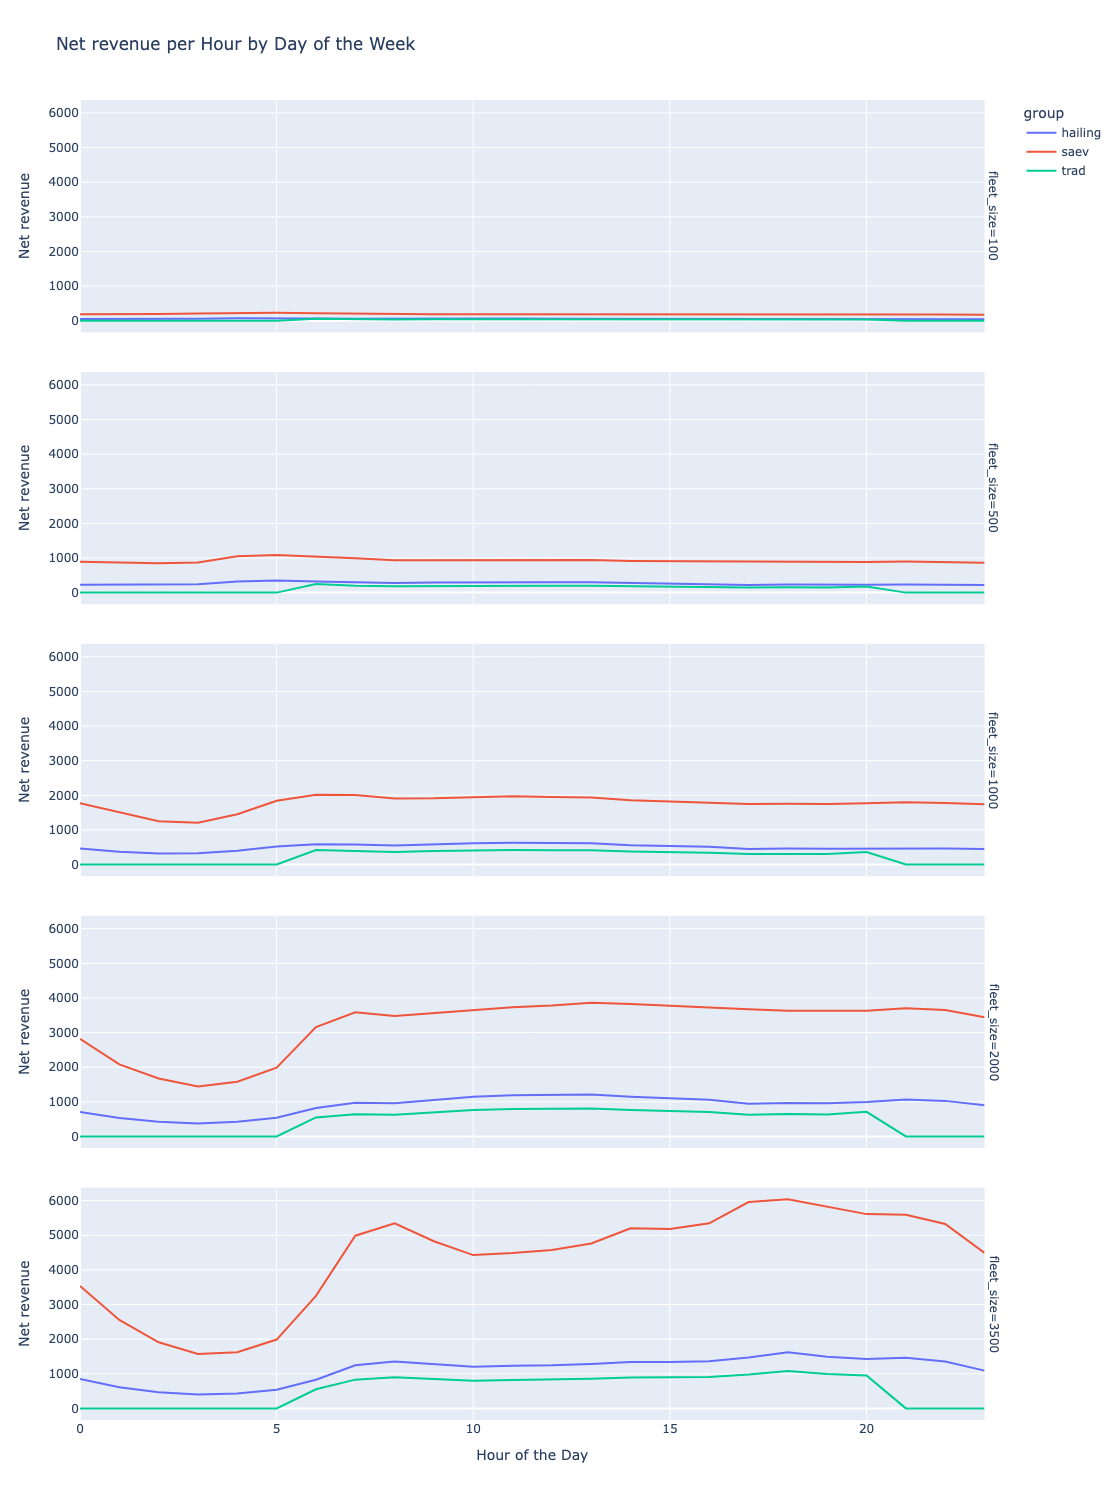

In [5]:
grouped = df.groupby(['hour_of_day', 'fleet_size', 'group'])['net_revenue'].mean().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped = grouped.sort_values(['hour_of_day', 'fleet_size', 'group'])

fig = px.line(
    grouped,
    x='hour_of_day',
    y='net_revenue',
    color='group',
    facet_row='fleet_size',
    labels={'hour_of_day': 'Hour of the Day', 'net_revenue': 'Net revenue'},
    title='Net revenue per Hour by Day of the Week'
)
fig.update_layout(
    height=1500,
    width=1100
)
fig.show()

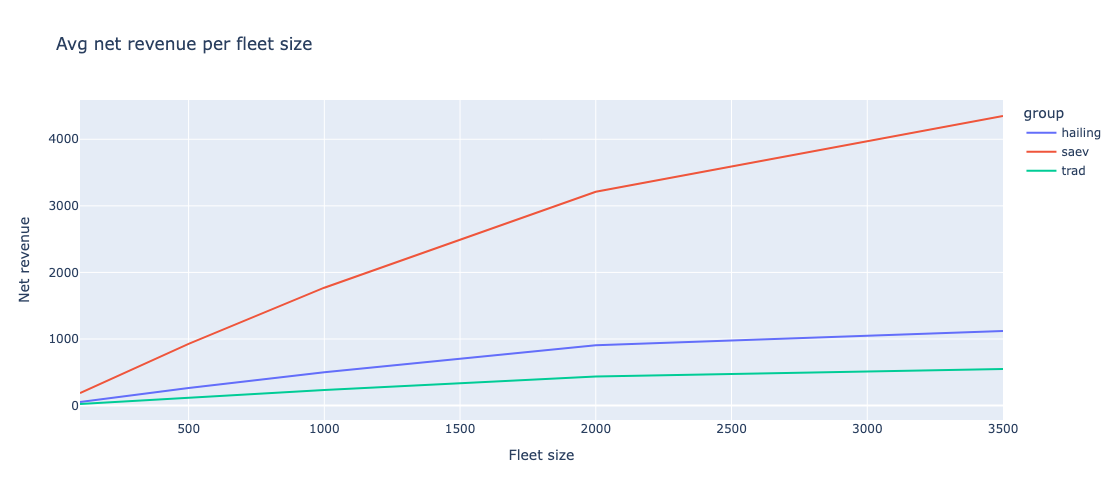

In [7]:
grouped = df.groupby(['fleet_size', 'group'])[['net_revenue', 'completed_trips']].mean().reset_index()

fig = px.line(
        grouped,
        x='fleet_size',
        y='net_revenue',
        color='group',
        title='Avg net revenue per fleet size',
        labels={'fleet_size': 'Fleet size', 'net_revenue': 'Net revenue'}
)

fig.update_layout(
    height=500,
    width=1000)

fig.show()

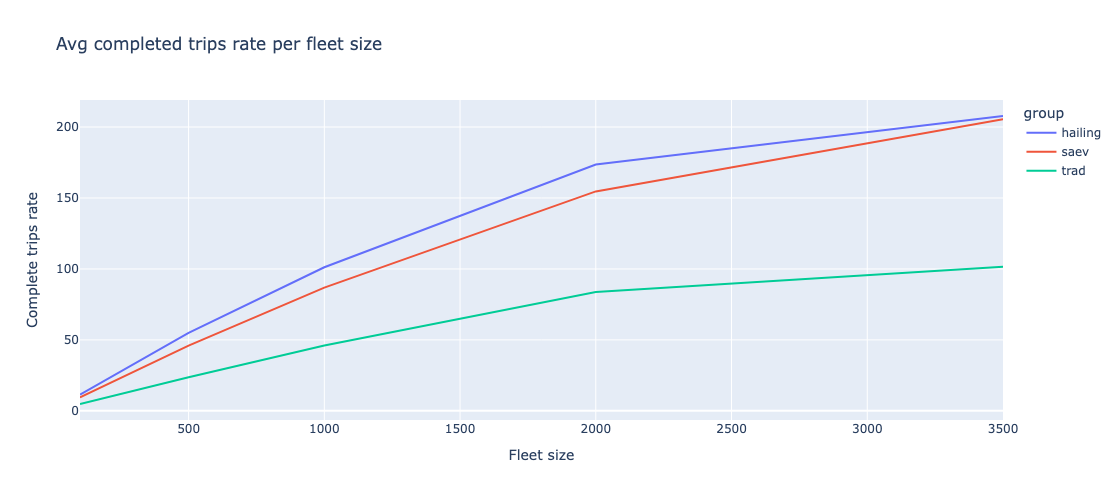

In [8]:
fig = px.line(
        grouped,
        x='fleet_size',
        y='completed_trips',
        color='group',
        title='Avg completed trips rate per fleet size',
        labels={'fleet_size': 'Fleet size', 'completed_trips': 'Complete trips rate'},
)

fig.update_layout(
    height=500,
    width=1000)

fig.show()

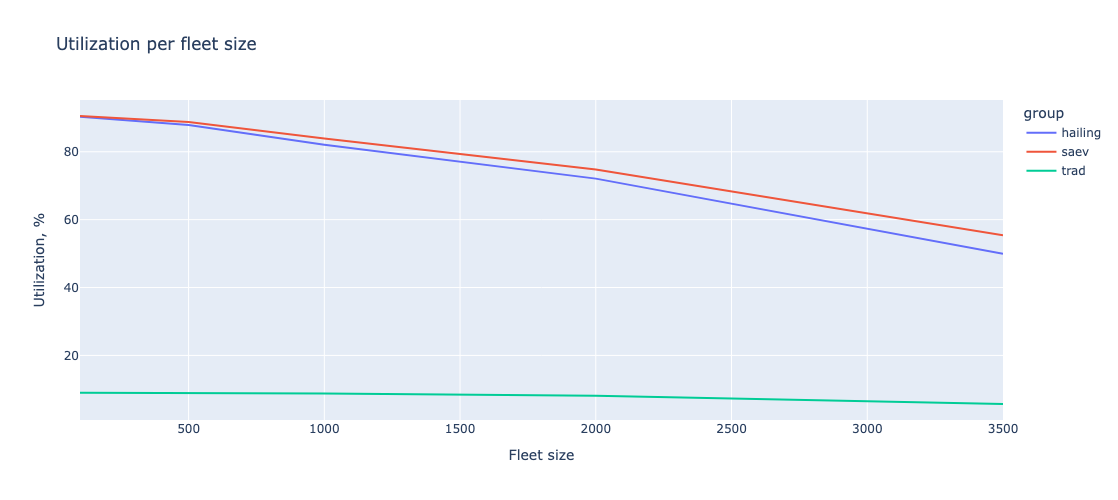

In [14]:
grouped = df.groupby(['fleet_size', 'group'])[['on_line_time', 'time_with_passenger']].sum().reset_index()
grouped['utilization'] = 100.0 * grouped['time_with_passenger'] / grouped['on_line_time']

fig = px.line(
        grouped,
        x='fleet_size',
        y='utilization',
        color='group',
        title='Utilization per fleet size',
        labels={'fleet_size': 'Fleet size', 'utilization': 'Utilization, %'}
)

fig.update_layout(
    height=500,
    width=1000)

fig.show()

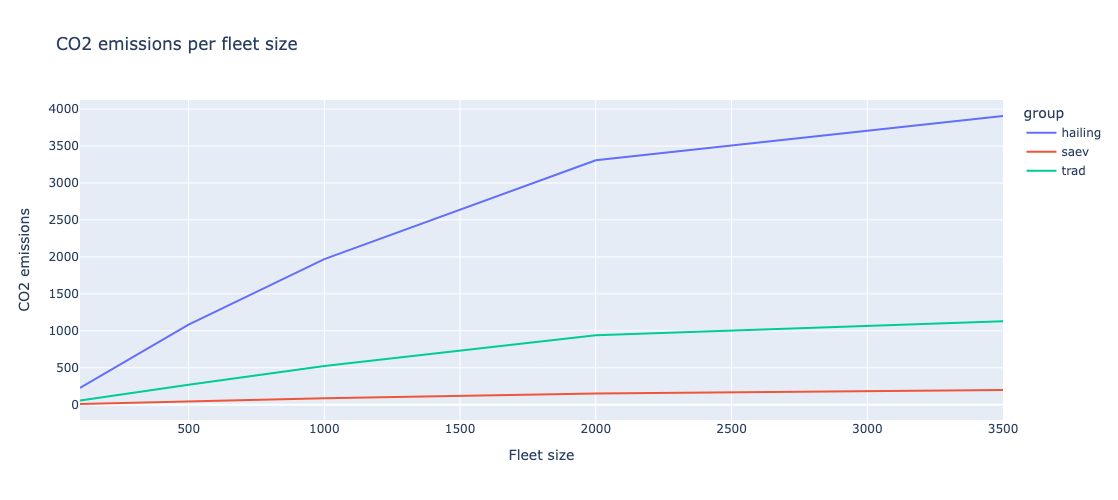

In [21]:
grouped = df.groupby(['fleet_size', 'group'])[['co2_emissions']].mean().reset_index()

fig = px.line(
        grouped,
        x='fleet_size',
        y='co2_emissions',
        color='group',
        title='CO2 emissions per fleet size',
        labels={'fleet_size': 'Fleet size', 'co2_emissions': 'CO2 emissions'}
)

fig.update_layout(
    height=500,
    width=1000)

fig.show()

# Hypothesis testing

In [5]:
combinations = [('trad', 'saev'), ('hailing', 'saev')]

In [6]:
fleet_sizes = [100, 500, 1000, 2000, 3500]

metric_description = {'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
                     'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
                     'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
                     'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
                     }

tag_names = list(df['group'].unique())

results = pd.DataFrame(
        columns=["metric_name", "group", "metric_value_left", "metric_value_right", "lift", "pval", "fleet_size"]
    )

for fleet in fleet_sizes:
    to_conduct = df[df['fleet_size'] == fleet]
    for metric, desc in metric_description.items():
        result = conduct_test(data=to_conduct,
                     nominator=desc['nominator'],
                     metric_name=metric,
                     combination=combinations,
                     tag_names=tag_names,
                     denominator=desc['denominator'],
                     alpha=0.01
                    )
        result['fleet_size'] = fleet
        results = pd.concat([results, result], axis=0)


/Users/enbelodedova/Documents/diploma.simulation/analysis/../stattool/experiment_tool.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([pd.DataFrame(row, index=[0]), results], axis=0)
/var/folders/xs/_0l9xrzj3tz9bsyngdnyxmhr0000gn/T/ipykernel_9115/3781768733.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result], axis=0)
/Users/enbelodedova/Documents/diploma.simulation/analysis/../stattool/experiment_tool.py:74: FutureWarning: The behav

In [7]:
results

metric_name            group  metric_value_left  metric_value_right  \
0    co2_emissions  hailing vs saev         226.724713            9.705676   
0    co2_emissions     trad vs saev          55.463503            9.705676   
0      net_revenue  hailing vs saev          53.747399          188.741191   
0      net_revenue     trad vs saev          23.292201          188.741191   
0      utilization  hailing vs saev           0.903251            0.905371   
0      utilization     trad vs saev           0.089855            0.905371   
0  completed_trips  hailing vs saev          11.495462            9.484706   
0  completed_trips     trad vs saev           4.826514            9.484706   
0    co2_emissions  hailing vs saev        1084.230955           46.923447   
0    co2_emissions     trad vs saev         271.345117           46.923447   
0      net_revenue  hailing vs saev         265.289523          926.356048   
0      net_revenue     trad vs saev         116.552560          926.356048   
0      utilization  hailing vs saev           0.878595            0.887810   
0      utilization     trad vs saev           0.089226            0.887810   
0  completed_trips  hailing vs saev          54.992000           45.942992   
0  completed_trips     trad vs saev          23.669341           45.942992   
0    co2_emissions  hailing vs saev        1969.298685           87.772963   
0    co2_emissions     trad vs saev         525.272203           87.772963   
0      net_revenue  hailing vs saev         501.081360         1770.341080   
0      net_revenue     trad vs saev         232.582641         1770.341080   
0      utilization  hailing vs saev           0.820625            0.838936   
0      utilization     trad vs saev           0.087605            0.838936   
0  completed_trips  hailing vs saev         101.164493           86.836840   
0  completed_trips     trad vs saev          46.023932           86.836840   
0    co2_emissions  hailing vs saev        3307.703212          153.259169   
0    co2_emissions     trad vs saev         940.252070          153.259169   
0      net_revenue  hailing vs saev         905.511277         3211.925574   
0      net_revenue     trad vs saev         438.282313         3211.925574   
0      utilization  hailing vs saev           0.720879            0.747454   
0      utilization     trad vs saev           0.081145            0.747454   
0  completed_trips  hailing vs saev         173.539661          154.642017   
0  completed_trips     trad vs saev          83.727244          154.642017   
0    co2_emissions  hailing vs saev        3906.053431          199.861632   
0    co2_emissions     trad vs saev        1128.076588          199.861632   
0      net_revenue  hailing vs saev        1121.168021         4349.766437   
0      net_revenue     trad vs saev         547.460248         4349.766437   
0      utilization  hailing vs saev           0.499214            0.554230   
0      utilization     trad vs saev           0.056850            0.554230   
0  completed_trips  hailing vs saev         207.781527          205.484472   
0  completed_trips     trad vs saev         101.610855          205.484472   

         lift           pval fleet_size is_reject  
0  -95.719180   0.000000e+00        100      True  
0  -82.500788   0.000000e+00        100      True  
0  251.163395   0.000000e+00        100      True  
0  710.319248   0.000000e+00        100      True  
0    0.234799   5.569277e-01        100     False  
0  907.587066   0.000000e+00        100      True  
0  -17.491740   0.000000e+00        100      True  
0   96.512566   0.000000e+00        100      True  
0  -95.672191   0.000000e+00        500      True  
0  -82.707097   0.000000e+00        500      True  
0  249.186820   0.000000e+00        500      True  
0  694.796824   0.000000e+00        500      True  
0    1.048816   1.059238e-06        500      True  
0  895.017767   0.000000e+00        500      True  
0  -16.455136   0.000000e+00

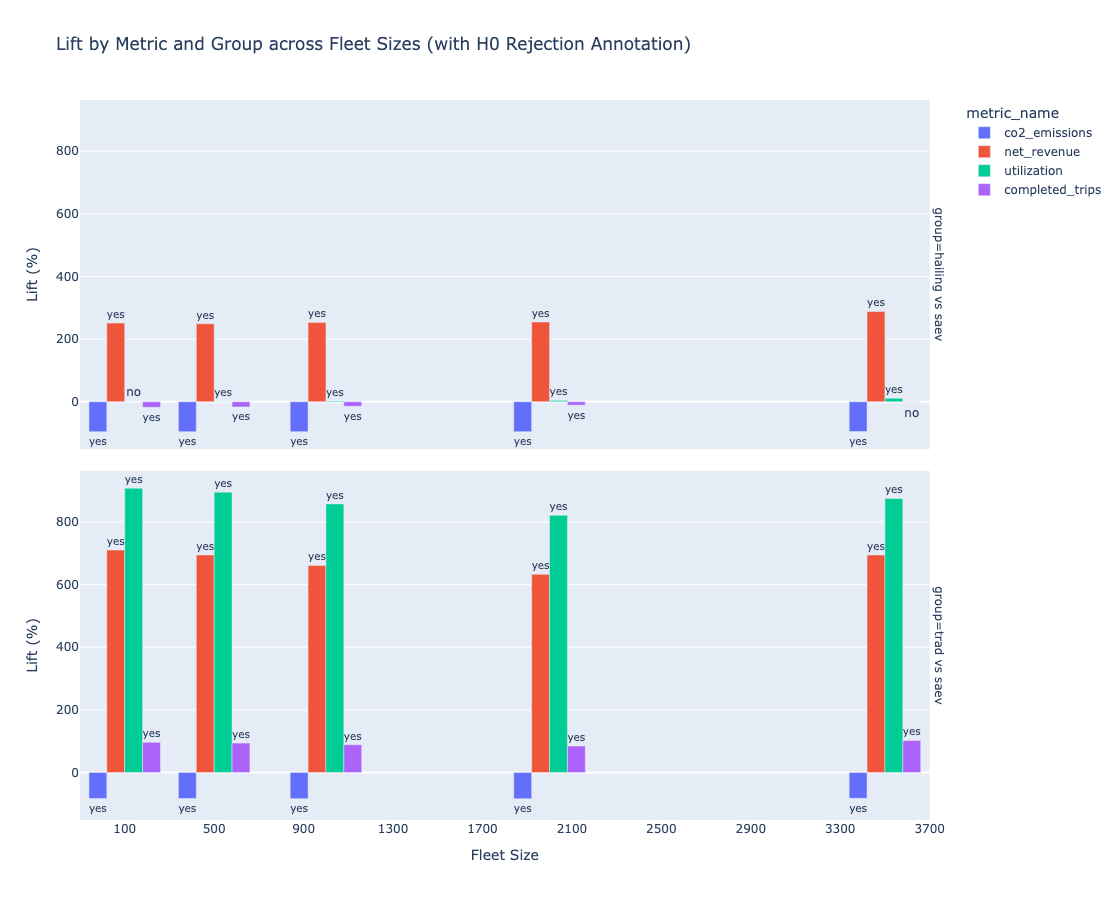

In [11]:
import pandas as pd
import plotly.express as px

# Make sure you don't filter anything — plot ALL results
# Assume `results` already has 'is_reject' column (True/False)

# Plot
fig = px.bar(
    results,
    x='fleet_size',
    y='lift',
    color='metric_name',
    facet_row='group',
    barmode='group',
    text=results['is_reject'].apply(lambda x: 'yes' if x else 'no'),  # map True/False to yes/no
    labels={'fleet_size': 'Fleet Size', 'lift': 'Lift (%)'},
    title='Lift by Metric and Group across Fleet Sizes (with H0 Rejection Annotation)'
)

fig.update_traces(textposition='outside')
fig.update_layout(height=900, width=1100)
fig.show()




/Users/enbelodedova/Documents/diploma.simulation/analysis/../stattool/experiment_tool.py:71: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/enbelodedova/Documents/diploma.simulation/analysis/../stattool/experiment_tool.py:71: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/enbelodedova/Documents/diploma.simulation/analysis/../stattool/experiment_tool.py:71: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wil

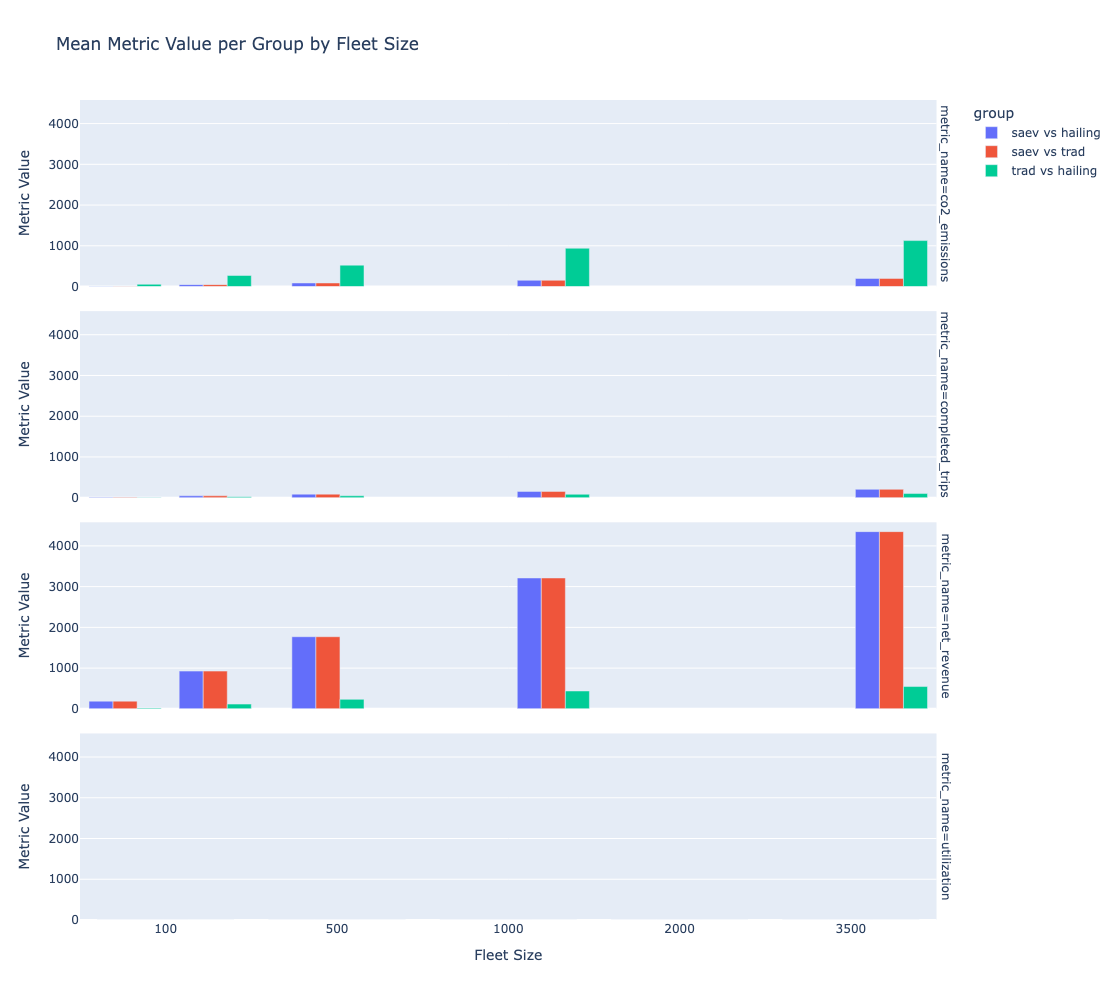

In [15]:
import pandas as pd
import plotly.express as px

fleet_sizes = [100, 500, 1000, 2000, 3500]

metric_description = {
    'co2_emissions': {'nominator': 'co2_emissions', 'denominator': 'default'},
    'net_revenue': {'nominator': 'net_revenue', 'denominator': 'default'},
    'utilization': {'nominator': 'time_with_passenger', 'denominator': 'on_line_time'},
    'completed_trips': {'nominator': 'completed_trips', 'denominator': 'default'},
}

tag_names = list(df['group'].unique())
all_results = []

for fleet in fleet_sizes:
    to_conduct = df[df['fleet_size'] == fleet]
    for metric, desc in metric_description.items():
        result = conduct_test(
            data=to_conduct,
            nominator=desc['nominator'],
            metric_name=metric,
            tag_names=tag_names,
            denominator=desc['denominator'],
            alpha=0.01
        )
        result['fleet_size'] = fleet
        all_results.append(result)

# Combine all results
results_df = pd.concat(all_results, axis=0)

# Prepare data for plotting
results_df['fleet_size'] = results_df['fleet_size'].astype(int)
plot_df = results_df.groupby(['fleet_size', 'group', 'metric_name'])['metric_value_left'].mean().reset_index()

# Plot
fig = px.bar(
    plot_df,
    x='fleet_size',
    y='metric_value_left',
    color='group',
    facet_row='metric_name',
    barmode='group',
    height=1000,
    width=1100,
    labels={'fleet_size': 'Fleet Size', 'metric_value_left': 'Metric Value'},
    title='Mean Metric Value per Group by Fleet Size'
)

fig.update_layout(xaxis_type='category')
fig.show()



In [ ]:
results = []

for fleet in fleet_sizes:
    fleet_data = df[df['fleet_size'] == fleet]
    
    for metric, desc in metric_description.items():
        groups_data = {
            group: fleet_data[fleet_data['group'] == group] 
            for group in ['traditional', 'saev', 'hailing']
        }
        
        for (group1, group2) in combinations(groups_data.keys(), 2):
            p_value = deltamethod(group1[nom], group1[den], group2[nom], group2[den], alternative='two-sided').pvalue
            
            results.append({
                'fleet_size': fleet,
                'metric': metric,
                'group1': group1,
                'group2': group2,
                'p_value': p_value
            })

results_df = pd.DataFrame(results)

significant_results = results_df[results_df['p_value'] < 0.05].sort_values(
    ['fleet_size', 'metric', 'p_value'])

print("Significant comparisons (p < 0.05):")
print(significant_results.to_string(index=False))